In [245]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm.notebook import tqdm

# import glob
# import imageio
# import os
# import PIL
# import time


torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch_float_dtype = torch.float
torch_int_dtype = torch.int

print(torch_device)


cpu


In [10]:
import sklearn.datasets
mnist_dataset = sklearn.datasets.fetch_openml('mnist_784')

In [12]:
X, Y = mnist_dataset.data.reshape(-1, 28, 28)/255. , mnist_dataset.target.astype(int)

X = torch.from_numpy(X).to(torch_device).type(torch_float_dtype)
Y = torch.from_numpy(Y).to(torch_device).type(torch_int_dtype)

del mnist_dataset

5


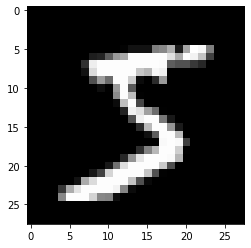

In [78]:
plt.imshow(X[0].cpu().numpy(), cmap='gray')
print(Y[0].cpu().numpy())

In [201]:
class GeneratorNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.leakyReLu = nn.LeakyReLU()
        
        self.lin1 = nn.Linear(100, 256*7*7)
        self.bn1 = nn.BatchNorm1d(1)
        self.convt1 = nn.ConvTranspose2d(256, 128, (5, 5), stride=(1, 1), padding=(2,2))
        self.bn2 = nn.BatchNorm2d(128)
        self.convt2 = nn.ConvTranspose2d(128, 64, (5, 5), stride=(2, 2), padding=(2,2), output_padding=(1,1))
        self.bn3 = nn.BatchNorm2d(64)
        self.convt3 = nn.ConvTranspose2d(64, 1, (5, 5), stride=(2, 2), padding=(2,2), output_padding=(1,1))
        
    def forward(self, x):
        x = self.lin1(x)

        x = x[:, None, :]
        x = self.bn1(x)
        x = self.leakyReLu(x)

        x = x.view(-1, 256, 7, 7)

        x = self.convt1(x)
        x = self.bn2(x)
        x = self.leakyReLu(x)

        x = self.convt2(x)
        x = self.bn3(x)
        x = self.leakyReLu(x)

        x = self.convt3(x)
        return x[:, 0, :, :]
        
gm = GeneratorNet()
gm = gm.to(torch_device)

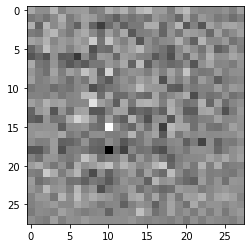

In [204]:
init_imgs = gm.forward(torch.zeros(10, 100))
# print(init_imgs.shape)
plt.imshow(init_imgs[0].cpu().detach().numpy(), cmap='gray')

In [131]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.leakyReLu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)
        
        self.conv1 = nn.Conv2d(1, 64, (5,5), stride=(2, 2), padding=(2,2))
        self.conv2 = nn.Conv2d(64, 128, (5,5), stride=(2, 2), padding=(2,2))
        self.lin = nn.Linear(128*7*7, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x[:, None, :, :]
        x = self.conv1(x)
        x = self.leakyReLu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.leakyReLu(x)
        x = self.dropout(x)
        
        x = x.view(-1, 128*7*7)
        x = self.lin(x)
        x = self.sigmoid(x)
        x = x[:, 0]
        return x
        
        
#         dm.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
#                                          input_shape=[28, 28, 1]))
#         dm.add(layers.LeakyReLU())
#         dm.add(layers.Dropout(0.3))

#         dm.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#         dm.add(layers.LeakyReLU())
#         dm.add(layers.Dropout(0.3))

#         dm.add(layers.Flatten())
#         dm.add(layers.Dense(1))


        
dm = DiscriminatorNet()
dm = dm.to(torch_device)

In [207]:
init_guesses = dm.forward(X[:5])
print(init_guesses.shape)

torch.Size([5])


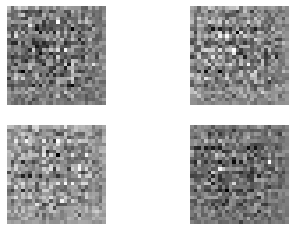

In [241]:
rows = 2
columns = 2
vis_noises = np.random.normal(0, 1, (rows*columns, 100))
vis_noises = torch.from_numpy(vis_noises).type(torch_float_dtype).to(torch_device)

def show_generator_model_images(gm):
    imgs = gm.forward(vis_noises).detach().cpu().numpy()
    
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.imshow(imgs[i, :, :], cmap='gray')
#         plt.colorbar()
        plt.axis('off')
    
    
show_generator_model_images(gm)

In [98]:
g_optim = torch.optim.Adam(gm.parameters(), lr=0.0001)
d_optim = torch.optim.Adam(dm.parameters(), lr=0.0001)

In [232]:
cross_entropy = nn.BCELoss()

# real_output is the output of discriminator with real input images
# fake_output is the output of discriminator with fake input images
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(real_output, torch.ones_like(real_output)) # want to correctly identify real
    fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output))  # want to correctly identify fake
    return real_loss + fake_loss

# fake_output is the output of discriminator with fake input images
def generator_loss(fake_output):
    return cross_entropy(fake_output, torch.ones_like(fake_output)) # want to trick discriminator with fake output

In [233]:
def train_step(image_batch):
    noise = np.random.normal(0, 1, (image_batch.shape[0], 100))
    noise = torch.from_numpy(noise).type(torch_float_dtype).to(torch_device)
    
    fake_image_batch = gm(noise) # run generator to get fake images

    real_output = dm(image_batch) # run discriminator on real images
    fake_output = dm(fake_image_batch) # run discriminator on fake images

    g_loss = generator_loss(fake_output) # needs one for loss function, only the one it generated
    d_loss = discriminator_loss(real_output, fake_output) # needs both for loss function

    g_loss.backward(retain_graph=True)
    d_loss.backward()
    
    g_optim.step()
    d_optim.step()
    g_optim.zero_grad()
    d_optim.zero_grad()

In [242]:
batch_size = 100

def train(images, epochs):
    for epoch in range(epochs):
        for i_batch in tqdm(range(images.shape[0] // batch_size)):
            image_batch = images[i_batch*batch_size:(i_batch+1)*batch_size]
            train_step(image_batch)
            
            if i_batch%10==0:
                show_generator_model_images(gm)
#                 plt.savefig(f'mnist_gan/epoch_{epoch:03d}_step_{i_batch:03d}')
#                 plt.close()
                plt.show()



  0%|          | 0/700 [00:00<?, ?it/s]

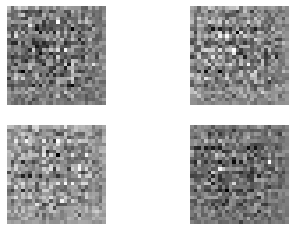


  1%|          | 6/700 [00:10<20:09,  1.74s/it]

KeyboardInterrupt: 

In [243]:
train(X, 10)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# train_images = np.stack((train_images, train_images, train_images), axis=3)
# train_images_color = train_images.copy()
# # train_images_color[train_images>0] = np.random.uniform(0, 255, train_images_color[train_images>0].shape)
# train_images_color[:, :, :, 1] = 0
# train_images_color[:, :, :, 2] = 0

def create_generator_model():
    gm = tf.keras.Sequential()
    gm.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    gm.add(layers.BatchNormalization())
    gm.add(layers.LeakyReLU())

    gm.add(layers.Reshape((7, 7, 256)))
    assert gm.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    gm.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert gm.output_shape == (None, 7, 7, 128)
    gm.add(layers.BatchNormalization())
    gm.add(layers.LeakyReLU())

    gm.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert gm.output_shape == (None, 14, 14, 64)
    gm.add(layers.BatchNormalization())
    gm.add(layers.LeakyReLU())

    gm.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert gm.output_shape == (None, 28, 28, 1)

    return gm
    

def create_discriminator_model():
    dm = tf.keras.Sequential()
    dm.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Flatten())
    dm.add(layers.Dense(1))

    return dm

gm = create_generator_model()
dm = create_discriminator_model()

rows = 10
columns = 10
vis_noises = np.random.normal(0, 1, (rows*columns, 100))

def show_generator_model_images(gm):
    imgs = gm.predict(vis_noises)
    
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
#         plt.colorbar()
        plt.axis('off')
show_generator_model_images(gm)

g_optim = tf.keras.optimizers.Adam(1e-4)
d_optim = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# real_output is the output of discriminator with real input images
# fake_output is the output of discriminator with fake input images
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # want to correctly identify real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # want to correctly identify fake
    return real_loss + fake_loss

# fake_output is the output of discriminator with fake input images
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # want to trick discriminator with fake output

@tf.function
def train_step(image_batch):
    noise = np.random.normal(0, 1, (image_batch.shape[0], 100))
    
    # gradient tapes needed to keep track of gradients (auto differentiation)
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_image_batch = gm(noise, training=True) # run generator to get fake images
        
        real_output = dm(image_batch[..., None], training=True) # run discriminator on real images
        fake_output = dm(fake_image_batch, training=True) # run discriminator on fake images
        
        g_loss = generator_loss(fake_output) # needs one for loss function, only the one it generated
        d_loss = discriminator_loss(real_output, fake_output) # needs both for loss function

    g_grad = g_tape.gradient(g_loss, gm.trainable_variables)
    d_grad = d_tape.gradient(d_loss, dm.trainable_variables)
    
    g_optim.apply_gradients(zip(g_grad, gm.trainable_variables))
    d_optim.apply_gradients(zip(d_grad, dm.trainable_variables))

batch_size = 100

def train(images, epochs):
    for epoch in range(epochs):
        for i_batch in tqdm(range(int(images.shape[0]/batch_size))):
            image_batch = images[i_batch*batch_size:(i_batch+1)*batch_size]
            train_step(image_batch)
            
            if i_batch%10==0:
                show_generator_model_images(gm)
                plt.savefig(f'mnist_gan/epoch_{epoch:03d}_step_{i_batch:03d}')
                plt.close()


train((train_images-127.5)/127.5, 10)



In [258]:
t_a = torch.tensor(3.)
t_b = torch.tensor(8.)
t_a.requires_grad = True
t_b.requires_grad = True

t_c = a*b

t_c.backward()

print(t_a.grad)

None
